In [31]:
# Paquetes !
# ----------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

# Importación de datos

In [2]:
# Importación de datos
# -----------------------------------------------------------
data = pd.read_csv('/content/books.csv', on_bad_lines='skip')
data

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,0439785960,9.780440e+12,eng,652.0,1944099.0,26249.0
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,0439358078,9.780439e+12,eng,870.0,1996446.0,27613.0
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,0439554934,9.780440e+12,eng,320.0,5629932.0,70390.0
3,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9.780440e+12,eng,352.0,6267.0,272.0
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,043965548X,9.780440e+12,eng,435.0,2149872.0,33964.0
...,...,...,...,...,...,...,...,...,...,...
9369,30243,Seduced by Moonlight (Merry Gentry #3),Laurell K. Hamilton,4.06,0553816322,9.780554e+12,eng,409.0,27755.0,394.0
9370,30244,The Killing Dance (Anita Blake Vampire Hunter...,Laurell K. Hamilton,4.13,0425209067,9.780425e+12,en-US,368.0,58410.0,912.0
9371,30245,Cerulean Sins (Anita Blake Vampire Hunter #11),Laurell K. Hamilton,3.85,0515136816,9.780515e+12,en-US,529.0,42807.0,701.0
9372,30246,Blue Moon (Anita Blake Vampire Hunter #8),Laurell K. Hamilton,4.05,0515134457,9.780515e+12,en-US,418.0,54799.0,812.0


Vemos que tenemos 10 variables con más de 10 mil datos donde 6 variables son cualitativas y 4 cuantitativas continuas. Para nuestro particular caso, queremos desarollar algoritmos de recomendación para predecir la mejor recomendación de un libro por cada usuario según su actividad y búsqueda. A continuación, una breve descripción de los datos cuantitativos,

In [3]:
# Descripción de las variables cuantitativas
# ------------------------------------------
data.describe()

,bookID,average_rating,isbn13,# num_pages,ratings_count,text_reviews_count
count,9374.000000,9373.000000,9.373000e+03,9373.000000,9.373000e+03,9373.000000
mean,14452.487199,3.940073,9.763105e+12,342.737864,2.149165e+04,625.834418
std,8612.583130,0.347697,4.081214e+11,253.164521,1.255766e+05,2717.355980
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,7093.750000,3.780000,9.780345e+12,193.000000,9.500000e+01,8.000000
50%,13984.000000,3.970000,9.780590e+12,299.000000,7.550000e+02,47.000000
75%,22062.500000,4.140000,9.780916e+12,422.000000,5.432000e+03,253.000000
max,30247.000000,5.000000,9.790008e+12,6576.000000,5.629932e+06,84237.000000


# Preparación de datos

Inicialmente, necesitamos filtrar información; es decir, para la variable "language_code" y "# num_pages" podemos preguntar al usuario qué idioma prefiere y si quiere un libro corto, intermedio o largo, según el siguiente diagrama de caja y la descripción de dicha variable,

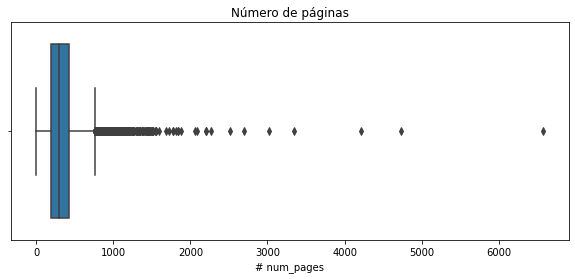

In [4]:
# Descripción de la variable
# -----------------------------------------
data['# num_pages'].describe()

# Diagrama de caja
# -----------------------------------------
plt.figure(figsize=(10,4))
sns.boxplot(x=data['# num_pages'])
plt.title('Número de páginas'); plt.show()

De este modo, ya podemos filtrar la información y descartar una gran cantidad de datos. Ahora veamos qué relación hay entre la cantidad de comentarios que tiene cada libro y sus calificaciones.

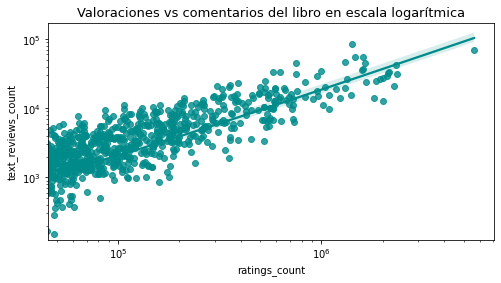

In [5]:
# Relación entre la cantidad de comentarios y calificaciones 
# --------------------------------------------------------------------------------
plt.figure(figsize=(8,4))
sns.regplot(x=data['ratings_count'],y=data['text_reviews_count'],color='darkcyan')
plt.title('Valoraciones vs comentarios del libro en escala logarítmica',size=13)
plt.xscale("log"); plt.yscale("log"); plt.show()

En efecto, ambas variables tienen una relación lineal acumulándose en cierta cantidad ya que hay libros que presentan estadísticas muy atípicas dada su fama. Y por tanto; entre mayores calificaciones tenga el libro, mayor serán sus comentarios. Recolectando entonces todos los filtros tendremos,

*   Idioma
*   Libros cortos, intermedios o largos
*   Mejor calificados
*   Más cometados y debatidos

# Recomendación de un libro según el nombre

Realizamos ahora una recomendación de libros según los filtros que elija el usuario y un nombre inicial de un libro utilizando la función '*TfidfVectorizer*' de *sklearn* y la similaridad del coseno la cual es un simple producto por escalar normalizado que se calcula de la siguiente manera; para $n\in\mathbb{N}$ tamaño de la muestra,
$$   K(X, Y) = \frac{<X, Y>}{||X||\cdot||Y||} = \frac{(x_1,x_2,\cdots,x_n)\cdot(y_1,y_2,\cdots,y_n)}{\sqrt{(x_1^2+x_2^2+\cdots+x_n^n)\cdot(y_1^2+y_2^2+\cdots+y_n^n)}}$$

En datos normalizados, esta función es equivalente a *'linear_kernel'* donde en nuestro caso particular, $X$ es el libro o palabra que estamos buscando y $Y$ los libros con mayor similitud en toda la base de datos. Es entonces cuando podemos darnos cuenta que cada $x_i\in X$ es la misma palabra o libro repetido $n-veces$ y es aquí donde usamos la función *'vectorizer'* para poder reemplazar en la similitud del coseno y organizar los datos de menor a mayor según su *'avg_rating'*; es decir, su puntaje promedio. Con el fin de mostrar de mayor a menor por puntaje la lista de las mejores recomendaciones.

In [47]:
# Recomendacion de libros con similitud del coseno
# ----------------------------------------------------------
def recomendacion_libro(query,Libro,go,com):
  data_ = data.copy()
  vectorizer = TfidfVectorizer(); titles = data_['title']
  data_["mod_title"] = data_["title"].str.replace("[^a-zA-Z0-9 ]", "", regex=True).str.lower()
  data_["mod_title"] = data_["mod_title"].str.replace("\s+", " ", regex=True)
  titles = data_[data_["mod_title"].str.len() > 0]
  tfidf = vectorizer.fit_transform(titles["mod_title"])
  processed = re.sub("[^a-zA-Z0-9 ]", "", query.lower())
  query_vec = vectorizer.transform([query])
  similarity = cosine_similarity(query_vec, tfidf).flatten()
  indices = np.argpartition(similarity, -10)[-10:]
  results = titles.iloc[indices]
  results = results.sort_values("average_rating", ascending=False)
  results.reset_index(inplace=True, drop=True)
  
  if Libro == 'Corto': return results[results['# num_pages']<200].head(go)
  if Libro == 'Intermedio': return results[results['# num_pages']<600].all().head(go)
  if Libro == 'Largo': return results[results['# num_pages']>1000].head(go)
  if Libro == 'Todos': return results.head(go)
  if com == True: return results[results['text_reviews_count']>10000].head(go)
  else: return results.head(go)

wd.interact(recomendacion_libro, 
    query = wd.Text(placeholder='Escribe aquí',description='Título del libro:'),
    Libro = wd.Dropdown(options=['Corto', 'Intermedio', 'Largo', 'Todos'], description='Extensión del libro: ', value=None),
    go = wd.BoundedIntText(value=0,step=1, description='¿Cuántos libros mostrar?:'),
    com = wd.Checkbox(value=False, description='Con mayor número de comentarios'))
plt.show()

interactive(children=(Text(value='', description='Título del libro:', placeholder='Escribe aquí'), Dropdown(de…